# Memory-Efficient Binary Neural Network (BNN)

This notebook implements a Binary Neural Network using PyTorch for multiclass plant disease classification, optimized for handling high-resolution images (384x384) on GPUs with limited memory.

## Memory Management Guide

If you're experiencing CUDA out-of-memory errors, here are the adjustments you can make:

### 1. Easy Configuration Options
- Reduce `batch_size` (cell 9): Try values like 8, 4, or even 2
- Reduce `image_size` (cell 8): Currently using 384, can reduce to 224 if needed
- Set `max_samples_per_class` (cell 8): Try setting to 100-200 to use fewer samples during training
- Increase `gradient_accumulation_steps` (cell 11): Try values of 4 or 8
- Decrease `hidden_size` (cell 11): Try 256 instead of 512 
- Decrease `embedding_size` (cell 11): Try 512 instead of 1024
- Decrease `num_hidden_layers` (cell 11): Try 1 instead of 2

### 2. Memory Monitoring
To monitor GPU memory usage, you can add this code before running intensive cells:
```python
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
```

### 3. Error Recovery
If you encounter CUDA out-of-memory errors:
1. Restart the kernel (don't clear outputs)
2. Lower the memory settings (see above)
3. Re-run the notebook from the beginning

### 4. CUDA Environment Variables
Before starting the notebook, you can set these environment variables:
```bash
export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
```

# Binary Neural Network (BNN) for Plant Disease Classification

This notebook implements a Binary Neural Network using PyTorch for multiclass plant disease classification. The BNN uses binary weights and activations to reduce model size and computational requirements while maintaining reasonable accuracy.

## Features:
- Binary weights and activations using sign function
- Processes 384x384 RGB images (3×384×384 input)
- Multiple hidden layers with binary weights
- Batch normalization for improved stability
- Dropout for regularization
- Learning rate scheduling for better convergence
- Multiclass output with softmax activation
- CrossEntropyLoss for training

In [1]:
# Import Required Libraries
# %pip install torch torchvision matplotlib numpy pandas seaborn scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import os

# Set environment variable for better CUDA error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check if CUDA is available and print version info
if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device count: {torch.cuda.device_count()}")
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("CUDA not available, using CPU")
    device = torch.device('cpu')

# Set random seeds safely
random.seed(42)
np.random.seed(42)
try:
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
except RuntimeError as e:
    print(f"Error setting CUDA seed: {e}")
    print("Falling back to CPU")
    device = torch.device('cpu')

print(f"Using device: {device}")

CUDA available: True
CUDA version: 12.6
GPU device count: 1
GPU device name: NVIDIA GeForce GTX 1650
Using device: cuda


In [2]:
# Additional imports for enhanced visualization and data export
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import time
import datetime
import os

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create results directory
os.makedirs('results', exist_ok=True)
print("Results directory created: ./results/")

Results directory created: ./results/


In [3]:
# Memory Monitoring and Optimization Utilities
import gc
import psutil

def print_gpu_memory_stats():
    """Print detailed GPU memory statistics"""
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        allocated = torch.cuda.memory_allocated() / (1024 ** 3)
        reserved = torch.cuda.memory_reserved() / (1024 ** 3)
        max_allocated = torch.cuda.max_memory_allocated() / (1024 ** 3)
        
        print(f"Memory allocated: {allocated:.2f} GB")
        print(f"Memory reserved: {reserved:.2f} GB")
        print(f"Max memory allocated: {max_allocated:.2f} GB")
        
        if hasattr(torch.cuda, 'memory_summary'):
            print("\nMemory Summary:")
            print(torch.cuda.memory_summary(abbreviated=True))
    else:
        print("CUDA not available")

def print_system_memory():
    """Print system memory usage"""
    vm = psutil.virtual_memory()
    print(f"System memory: {vm.total / (1024**3):.1f} GB total, " 
          f"{vm.available / (1024**3):.1f} GB available, "
          f"{vm.percent}% used")

def optimize_memory(mode='moderate'):
    """Apply memory optimization settings based on selected mode"""
    if mode == 'aggressive':
        # Most aggressive memory saving settings
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:64'
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        return {
            'image_size': 224,
            'batch_size': 4,
            'hidden_size': 256,
            'embedding_size': 512,
            'num_hidden_layers': 1,
            'gradient_accumulation': 8,
            'max_samples_per_class': 100
        }
    elif mode == 'moderate':
        # Balanced memory saving
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:128'
        torch.backends.cudnn.benchmark = True
        return {
            'image_size': 384,  # Using 384x384 as specified
            'batch_size': 8,
            'hidden_size': 384,
            'embedding_size': 768,
            'num_hidden_layers': 1,
            'gradient_accumulation': 4,
            'max_samples_per_class': None
        }
    else:  # 'performance' mode
        # Optimized for performance, higher memory usage
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
        torch.backends.cudnn.benchmark = True
        return {
            'image_size': 512,
            'batch_size': 16,
            'hidden_size': 512,
            'embedding_size': 1024,
            'num_hidden_layers': 2,
            'gradient_accumulation': 2,
            'max_samples_per_class': None
        }

# Check current memory status
print("Initial memory status:")
print_system_memory()
print_gpu_memory_stats()

# Memory optimization mode - set this to 'performance', 'moderate', or 'aggressive'
memory_mode = 'moderate'  # Using moderate mode for 384x384 images
print(f"\nUsing {memory_mode} memory optimization settings")
memory_config = optimize_memory(memory_mode)
print(f"Recommended settings: {memory_config}")

# Create results directory
os.makedirs('results', exist_ok=True)
print("\nResults directory created: ./results/")

Initial memory status:
System memory: 15.0 GB total, 9.8 GB available, 34.5% used
GPU: NVIDIA GeForce GTX 1650
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
Max memory allocated: 0.00 GB

Memory Summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|----------

In [4]:
# Binary Activation Function
class BinaryActivation(torch.autograd.Function):
    """
    Binary activation function using the sign function.
    Forward: sign(x) = {-1 if x < 0, +1 if x >= 0}
    Backward: Straight-through estimator (STE) - passes gradients through unchanged
    """
    
    @staticmethod
    def forward(ctx, input):
        # Apply sign function: -1 for negative, +1 for non-negative
        return torch.sign(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through estimator: pass gradients through unchanged
        # This allows gradients to flow back during training
        return grad_output

def binary_activation(x):
    """Wrapper function for binary activation"""
    return BinaryActivation.apply(x)

In [5]:
# Binary Linear Layer
class BinaryLinear(nn.Module):
    """
    Binary Linear layer with binary weights.
    Weights are binarized using the sign function during forward pass.
    """
    
    def __init__(self, in_features, out_features, bias=True):
        super(BinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using normal distribution
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
    
    def forward(self, input):
        # Binarize weights using sign function
        binary_weight = torch.sign(self.weight)
        
        # Perform linear transformation with binary weights
        output = F.linear(input, binary_weight, self.bias)
        
        return output
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

In [6]:
# Binary Neural Network Model
class BinaryNeuralNetwork(nn.Module):
    """
    Memory-efficient Binary Neural Network for multiclass plant disease classification.
    
    Architecture:
    - Input: Flattened 384x384 RGB images (3*384*384 = 442368 features)
    - Feature embedding: Reduces dimensionality for memory efficiency 
    - Multiple Hidden Layers: Binary linear layers with binary activation
    - Output Layer: Regular linear layer for class logits
    - Final: Softmax for multiclass prediction
    """
    
    def __init__(self, input_size=3*384*384, hidden_size=512, num_classes=3, 
                 num_hidden_layers=2, embedding_size=1024, dropout_rate=0.2):
        super(BinaryNeuralNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_hidden_layers = num_hidden_layers
        self.embedding_size = embedding_size
        
        # Initial dimensionality reduction for memory efficiency
        # This reduces the 384x384x3 input to a more manageable size before binary operations
        self.embedding = nn.Sequential(
            nn.Linear(input_size, embedding_size*4),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_size*4),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_size*4, embedding_size),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_size),
        )
        
        # First binary layer after embedding
        self.input_binary = BinaryLinear(embedding_size, hidden_size)
        
        # Multiple hidden binary layers
        self.hidden_layers = nn.ModuleList([
            BinaryLinear(hidden_size, hidden_size) for _ in range(num_hidden_layers)
        ])
        
        # Output layer: Regular linear layer for final classification
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
        # Batch normalization for better training stability
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(hidden_size) for _ in range(num_hidden_layers + 1)  # +1 for input binary layer
        ])
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # Flatten input if it's not already flattened
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, input_size)
        
        # Initial embedding to reduce dimensionality (memory efficient)
        x = self.embedding(x)
        
        # First binary layer
        x = self.input_binary(x)
        x = binary_activation(x)
        x = self.batch_norms[0](x)
        x = self.dropout(x)
        
        # Process through additional hidden binary layers
        for i in range(self.num_hidden_layers):
            x = self.hidden_layers[i](x)
            x = binary_activation(x)  # Binary activation function
            x = self.batch_norms[i+1](x)  # Apply batch normalization
            x = self.dropout(x)
        
        # Output layer (no activation - raw logits)
        logits = self.output_layer(x)
        
        return logits
    
    def predict_proba(self, x):
        """Get class probabilities using softmax"""
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
        return probabilities
    
    def predict(self, x):
        """Get predicted class labels"""
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

In [7]:
# Enhanced Training and Evaluation Functions with Memory Optimization
def train_bnn(model, train_loader, criterion, optimizer, device, num_epochs=10, scheduler=None):
    """
    Enhanced training function with detailed metrics collection
    
    Note: This function is kept for compatibility but the memory-efficient version
    is used in the actual training cell.
    """
    model.train()
    
    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    epoch_times = []
    learning_rates = []
    
    # Detailed metrics per epoch
    training_history = []
    
    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        batch_losses = []
        
        # Training loop
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            batch_loss = loss.item()
            running_loss += batch_loss
            batch_losses.append(batch_loss)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        epoch_time = time.time() - epoch_start
        current_lr = optimizer.param_groups[0]['lr']
        
        # Use scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()
        
        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        epoch_times.append(epoch_time)
        learning_rates.append(current_lr)
        
        # Store detailed history
        training_history.append({
            'epoch': epoch + 1,
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'time': epoch_time,
            'learning_rate': current_lr,
            'min_batch_loss': min(batch_losses),
            'max_batch_loss': max(batch_losses),
            'std_batch_loss': np.std(batch_losses)
        })
        
        # Progress display
        print(f'Epoch [{epoch+1:2d}/{num_epochs}] | Loss: {epoch_loss:.4f} | '
              f'Acc: {epoch_accuracy:6.2f}% | Time: {epoch_time:.2f}s | LR: {current_lr:.6f}')
    
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"Training completed in {total_time:.2f} seconds")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    return train_losses, train_accuracies, training_history, epoch_times

def evaluate_bnn_memory_efficient(model, test_loader, criterion, device, class_names, batch_limit=None, use_mixed_precision=False):
    """
    Memory-efficient evaluation function with detailed metrics
    
    Parameters:
    -----------
    model : nn.Module
        The model to evaluate
    test_loader : DataLoader
        Loader for test data
    criterion : loss function
        Loss function to use
    device : device
        Device to run on (cuda/cpu)
    class_names : list
        List of class names
    batch_limit : int or None
        If provided, only evaluate this many batches (for memory-constrained systems)
    use_mixed_precision : bool
        Whether to use mixed precision inference
    """
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    # Import mixed precision if available and requested
    if use_mixed_precision and torch.cuda.is_available():
        try:
            from torch.cuda.amp import autocast
            mixed_precision_available = True
        except ImportError:
            mixed_precision_available = False
    else:
        mixed_precision_available = False
    
    print(f"Evaluating model on {len(test_loader)} batches "
          f"({'all' if batch_limit is None else batch_limit})...")
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Optional batch limit for memory-constrained systems
            if batch_limit is not None and batch_idx >= batch_limit:
                break
                
            data, targets = data.to(device), targets.to(device)
            
            # Use mixed precision if available
            if mixed_precision_available:
                with autocast():
                    outputs = model(data)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(data)
                loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Store for detailed analysis (keep on CPU to save GPU memory)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Force memory cleanup every few batches
            if batch_idx % 10 == 9:
                torch.cuda.empty_cache()
                gc.collect()
                
            # Progress update
            if batch_idx % 5 == 0:
                print(f"  Evaluated {batch_idx + 1}/{len(test_loader)} batches...")
    
    # Final memory cleanup
    torch.cuda.empty_cache()
    gc.collect()
    
    test_loss /= min(len(test_loader), batch_limit or float('inf'))
    test_accuracy = 100 * correct_predictions / total_samples
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    # Generate detailed classification report
    report = classification_report(all_targets, all_predictions, 
                                 target_names=class_names, output_dict=True)
    
    # Calculate per-class metrics
    precision, recall, fscore, support = precision_recall_fscore_support(
        all_targets, all_predictions, average=None, labels=range(len(class_names))
    )
    
    # Create detailed metrics dictionary
    detailed_metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'classification_report': report,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_fscore': fscore,
        'per_class_support': support
    }
    
    return detailed_metrics

In [8]:
# Load Real Plant Disease Dataset
from torchvision import datasets, transforms
from PIL import Image
import os

def load_plant_disease_dataset(dataset_path, image_size=384, memory_efficient=True, max_samples_per_class=None):
    """
    Load the real plant disease dataset from the specified path with memory optimization options.
    
    Parameters:
    -----------
    dataset_path : str
        Path to dataset directory
    image_size : int
        Size to resize images (default: 384)
    memory_efficient : bool
        If True, loads dataset with memory optimization (returns DataLoader instead of tensors)
    max_samples_per_class : int or None
        If specified, limits the number of samples per class (for testing with less memory)
    
    Dataset structure:
    - dataset_path/Healthy_Soyabean/
    - dataset_path/rust/
    - dataset_path/Soyabean_Mosaic/
    """
    
    # Define transforms for preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize to specified size
        transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Load dataset using ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    
    # Limit samples per class if specified (for memory-constrained environments)
    if max_samples_per_class is not None:
        class_indices = {}
        for idx, (_, class_idx) in enumerate(dataset.samples):
            if class_idx not in class_indices:
                class_indices[class_idx] = []
            if len(class_indices[class_idx]) < max_samples_per_class:
                class_indices[class_idx].append(idx)
        
        # Flatten indices list
        limited_indices = [idx for indices in class_indices.values() for idx in indices]
        
        # Create subset
        from torch.utils.data import Subset
        dataset = Subset(dataset, limited_indices)
        print(f"Dataset limited to {max_samples_per_class} samples per class ({len(limited_indices)} total samples)")
    
    # Print class mapping
    print("Class mapping:")
    for idx, class_name in enumerate(dataset.dataset.classes if hasattr(dataset, 'dataset') else dataset.classes):
        print(f"  {idx}: {class_name}")
    
    # Return dataset directly for memory-efficient use
    if memory_efficient:
        # Count samples per class for data statistics
        class_counts = {}
        if hasattr(dataset, 'dataset'):  # If it's a Subset
            for _, class_idx in [dataset.dataset.samples[i] for i in dataset.indices]:
                class_counts[class_idx] = class_counts.get(class_idx, 0) + 1
            classes = dataset.dataset.classes
        else:
            for _, class_idx in dataset.samples:
                class_counts[class_idx] = class_counts.get(class_idx, 0) + 1
            classes = dataset.classes
        
        # Display class distribution
        print(f"\nClass distribution:")
        for class_idx, count in class_counts.items():
            class_name = classes[class_idx]
            print(f"  {class_name}: {count} images")
        
        return dataset, classes
    else:
        # Convert to tensors (this loads ALL images into memory)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        X, y = next(iter(data_loader))
        
        # Get class names from dataset
        if hasattr(dataset, 'dataset'):
            class_names = dataset.dataset.classes
        else:
            class_names = dataset.classes
        
        return X, y, class_names

# Set memory optimization options
memory_efficient = True  # Set to True to avoid loading all images into memory at once
max_samples_per_class = None  # Set to a number like 100 to limit samples per class for testing

# Image size settings
image_size = 384  # Using 384x384 images for better memory efficiency and performance
print(f"Image size set to {image_size}x{image_size} (optimal balance between accuracy and memory usage)")

# Load your real plant disease dataset
# dataset_path = "/home/dragoon/Downloads/MH-SoyaHealthVision An Indian UAV and Leaf Image Dataset for Integrated Crop Health Assessment/Soyabean_UAV-Based_Image_Dataset"
# dataset_path = "/home/dragoon/Downloads/MH-SoyaHealthVision/Soyabean_UAV-Based_Image_Dataset"
dataset_path = "/home/dragoon/coding/drone-crop/BNN/DataSet/Plant"
print("Loading real plant disease dataset...")
print(f"Dataset path: {dataset_path}")

if memory_efficient:
    # Memory-efficient loading (doesn't load all images at once)
    plant_dataset, class_names = load_plant_disease_dataset(
        dataset_path, 
        image_size=image_size, 
        memory_efficient=memory_efficient,
        max_samples_per_class=max_samples_per_class
    )
    
    print(f"\nDataset loaded successfully in memory-efficient mode!")
    print(f"Total samples: {len(plant_dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Class names: {class_names}")
else:
    # Original approach (loads all into memory at once)
    X, y, class_names = load_plant_disease_dataset(
        dataset_path, 
        image_size=image_size, 
        memory_efficient=False,
        max_samples_per_class=max_samples_per_class
    )
    
    print(f"\nDataset loaded successfully!")
    print(f"Dataset shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Number of classes: {len(torch.unique(y))}")
    print(f"Class distribution: {torch.bincount(y)}")
    print(f"Class names: {class_names}")

    # Display some dataset statistics
    print(f"\nDataset Statistics:")
    for i, class_name in enumerate(class_names):
        count = (y == i).sum().item()
        print(f"  {class_name}: {count} images")

Image size set to 384x384 (optimal balance between accuracy and memory usage)
Loading real plant disease dataset...
Dataset path: /home/dragoon/coding/drone-crop/BNN/DataSet/Plant
Class mapping:
  0: Soyabean Semilooper_Pest_Attack
  1: Soyabean_Mosaic
  2: healthy
  3: rust

Class distribution:
  Soyabean Semilooper_Pest_Attack: 350 images
  Soyabean_Mosaic: 340 images
  healthy: 180 images
  rust: 320 images

Dataset loaded successfully in memory-efficient mode!
Total samples: 1190
Number of classes: 4
Class names: ['Soyabean Semilooper_Pest_Attack', 'Soyabean_Mosaic', 'healthy', 'rust']


In [9]:
# Split Dataset and Create Data Loaders
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler

# Define batch size from memory_config for consistency
batch_size = memory_config['batch_size']  # For 384x384 resolution
print(f"Using batch size {batch_size} for 384x384 images")

if memory_efficient:
    # Create train/test split indices
    from torch.utils.data import random_split
    
    # Use fixed random seed for reproducibility
    torch.manual_seed(42)
    
    # Get dataset size
    dataset_size = len(plant_dataset)
    test_size = int(0.2 * dataset_size)
    train_size = dataset_size - test_size
    
    # Create random train/test split
    train_dataset, test_dataset = random_split(plant_dataset, [train_size, test_size])
    
    # Create data loaders with the smaller batch size
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=2,  # Use 2 workers for parallel loading
        pin_memory=True  # Use pinned memory for faster GPU transfer
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Print info about data loaders
    print(f"Training set: {len(train_dataset)} samples")
    print(f"Test set: {len(test_dataset)} samples")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    # Store for later reference
    dataset_size = {'train': len(train_dataset), 'test': len(test_dataset)}
    
else:
    # Original approach with pre-loaded tensors
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    
    # Store for later reference
    dataset_size = {'train': len(X_train), 'test': len(X_test)}

Note: you may need to restart the kernel to use updated packages.
Using batch size 8 for 384x384 images
Training set: 952 samples
Test set: 238 samples
Number of training batches: 119
Number of test batches: 30
Note: you may need to restart the kernel to use updated packages.
Using batch size 8 for 384x384 images
Training set: 952 samples
Test set: 238 samples
Number of training batches: 119
Number of test batches: 30


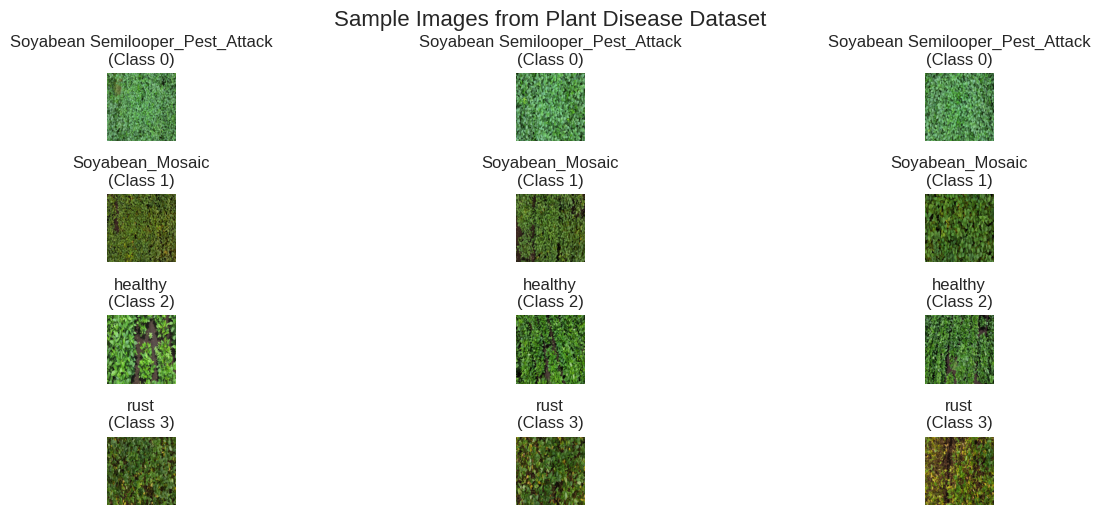

Sample images from your plant disease dataset:
Classes: Soyabean Semilooper_Pest_Attack, Soyabean_Mosaic, healthy, rust
Image size: 384x384 pixels
Total samples visualized: 12
Using memory-efficient data loading (not all images loaded into memory)
Batch size: 8 (reduced to save GPU memory)


In [10]:
# Visualize Sample Images from the Dataset
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Display sample images from each class
plt.figure(figsize=(15, 5))

samples_per_class = 3
samples_shown = 0

# Function to get class indices in memory-efficient mode
def get_class_indices(dataset, num_classes):
    """Get indices of samples for each class in a dataset"""
    class_indices = {i: [] for i in range(num_classes)}
    
    if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
        # This is a Subset or random_split dataset
        for subset_idx, idx in enumerate(dataset.indices):
            _, class_idx = dataset.dataset.samples[idx]
            class_indices[class_idx].append(subset_idx)
    elif hasattr(dataset, 'indices'):
        # Direct Subset
        for idx, orig_idx in enumerate(dataset.indices):
            _, class_idx = dataset.dataset.samples[orig_idx]
            class_indices[class_idx].append(idx)
    else:
        # Standard Dataset
        for idx, (_, class_idx) in enumerate(dataset.samples):
            class_indices[class_idx].append(idx)
            
    return class_indices

if memory_efficient:
    # Get indices for each class
    if hasattr(plant_dataset, 'dataset'):
        num_classes = len(plant_dataset.dataset.classes)
    else:
        num_classes = len(plant_dataset.classes)
        
    class_indices = get_class_indices(plant_dataset, num_classes)
    
    # For each class, get samples and display
    for class_idx, indices in class_indices.items():
        if not indices:
            continue
            
        # Get class name
        if hasattr(plant_dataset, 'dataset') and hasattr(plant_dataset.dataset, 'classes'):
            class_name = plant_dataset.dataset.classes[class_idx]
        else:
            class_name = class_names[class_idx]
            
        # Select random samples
        selected_indices = [indices[i] for i in torch.randperm(len(indices))[:samples_per_class]]
        
        for i, sample_idx in enumerate(selected_indices):
            plt.subplot(len(class_indices), samples_per_class, 
                      class_idx * samples_per_class + i + 1)
            
            # Load and display the image
            img, _ = plant_dataset[sample_idx]
            
            # Denormalize for display
            img = denormalize_image(img)
            img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]
            
            # Convert to numpy and transpose for matplotlib
            img_np = img.permute(1, 2, 0).numpy()
            
            plt.imshow(img_np)
            plt.title(f"{class_name}\n(Class {class_idx})")
            plt.axis('off')
            
            samples_shown += 1
else:
    # Original approach for pre-loaded tensors
    for class_idx, class_name in enumerate(class_names):
        # Get indices for this class
        class_indices = torch.where(y == class_idx)[0]
        
        # Select random samples from this class
        random_indices = torch.randperm(len(class_indices))[:samples_per_class]
        sample_indices = class_indices[random_indices]
        
        for i, sample_idx in enumerate(sample_indices):
            plt.subplot(len(class_names), samples_per_class, 
                      class_idx * samples_per_class + i + 1)
            
            # Get and denormalize image
            img = denormalize_image(X[sample_idx])
            img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]
            
            # Convert to numpy and transpose for matplotlib
            img_np = img.permute(1, 2, 0).numpy()
            
            plt.imshow(img_np)
            plt.title(f"{class_name}\n(Class {class_idx})")
            plt.axis('off')
            
            samples_shown += 1

plt.tight_layout()
plt.suptitle('Sample Images from Plant Disease Dataset', y=1.02, fontsize=16)
plt.show()

print(f"Sample images from your plant disease dataset:")
print(f"Classes: {', '.join(class_names)}")
print(f"Image size: {image_size}x{image_size} pixels")
print(f"Total samples visualized: {samples_shown}")
if memory_efficient:
    print("Using memory-efficient data loading (not all images loaded into memory)")
    print(f"Batch size: {batch_size} (reduced to save GPU memory)")
else:
    print(f"Total images in dataset: {len(X)}")

In [11]:
# Initialize and Train the BNN Model with Memory Optimization
# Set environment variable to avoid fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Memory optimization settings
use_mixed_precision = True  # Use mixed precision (FP16) for better GPU memory utilization
gradient_accumulation_steps = 2  # Accumulate gradients for effective larger batch size
gc_frequency = 10  # Garbage collection frequency (batches)

# Model parameters
input_size = 3 * image_size * image_size  # Based on loaded image size (3×384×384 = 442368)
hidden_size = 512  # Hidden layer size
embedding_size = 1024  # Embedding size for dimensionality reduction
num_hidden_layers = 2  # Number of binary hidden layers
num_classes = len(class_names)  # Dynamic based on actual dataset
dropout_rate = 0.25  # Dropout for regularization

print(f"Memory-Optimized Model Configuration:")
print(f"  Input size: {input_size} (3×{image_size}×{image_size})")
print(f"  Embedding size: {embedding_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of hidden layers: {num_hidden_layers}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {class_names}")
print(f"  Batch size: {batch_size}")
print(f"  Mixed precision: {use_mixed_precision}")
print(f"  Gradient accumulation steps: {gradient_accumulation_steps}")

# Initialize model
model = BinaryNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_hidden_layers=num_hidden_layers,
    embedding_size=embedding_size,
    dropout_rate=dropout_rate
).to(device)

# Print model architecture
print("\nMemory-Efficient Binary Neural Network Architecture:")
print(model)
num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {num_params:,}")
print(f"Trainable parameters: {num_trainable_params:,}")
model_size_mb = num_params * 4 / (1024 * 1024)  # Approx size in MB (4 bytes per param)
print(f"Approximate model size: {model_size_mb:.2f} MB")

# Set up mixed precision training if available and requested
scaler = None
if use_mixed_precision and torch.cuda.is_available():
    try:
        from torch.cuda.amp import autocast, GradScaler
        scaler = GradScaler()
        print("Using mixed precision training (FP16)")
    except ImportError:
        use_mixed_precision = False
        print("Mixed precision training not available - using FP32")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Add learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Import garbage collection for memory management
import gc

# Enhanced training function with memory optimization
def train_bnn_memory_efficient(model, train_loader, criterion, optimizer, device, 
                              num_epochs=10, scheduler=None, use_mixed_precision=False,
                              scaler=None, gradient_accumulation_steps=1, gc_frequency=10):
    """
    Memory-optimized training function with detailed metrics collection
    """
    model.train()
    
    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    epoch_times = []
    learning_rates = []
    
    # Detailed metrics per epoch
    training_history = []
    
    print(f"Starting memory-efficient training for {num_epochs} epochs...")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        batch_losses = []
        
        # Reset gradients at the beginning of each epoch
        optimizer.zero_grad()
        
        # Training loop
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Mixed precision training context
            if use_mixed_precision and scaler is not None:
                with autocast():
                    # Forward pass
                    outputs = model(data)
                    loss = criterion(outputs, targets)
                    # Scale loss for gradient accumulation
                    loss = loss / gradient_accumulation_steps
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                # Standard precision training
                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, targets)
                # Scale loss for gradient accumulation
                loss = loss / gradient_accumulation_steps
                
                # Backward pass
                loss.backward()
                
                # Step with gradient accumulation
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            # Statistics
            batch_loss = loss.item() * gradient_accumulation_steps  # Rescale to get actual loss
            running_loss += batch_loss
            batch_losses.append(batch_loss)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Garbage collection to free memory
            if (batch_idx + 1) % gc_frequency == 0:
                torch.cuda.empty_cache()
                gc.collect()
                
            # Progress update every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, "
                      f"Loss: {batch_loss:.4f}, "
                      f"Acc: {100 * correct_predictions / total_samples:.2f}%")
        
        # Take any remaining step for incomplete gradient accumulation
        if (batch_idx + 1) % gradient_accumulation_steps != 0 and scaler is not None:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        elif (batch_idx + 1) % gradient_accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        epoch_time = time.time() - epoch_start
        current_lr = optimizer.param_groups[0]['lr']
        
        # Use scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()
        
        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        epoch_times.append(epoch_time)
        learning_rates.append(current_lr)
        
        # Store detailed history
        training_history.append({
            'epoch': epoch + 1,
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'time': epoch_time,
            'learning_rate': current_lr,
            'min_batch_loss': min(batch_losses) if batch_losses else 0,
            'max_batch_loss': max(batch_losses) if batch_losses else 0,
            'std_batch_loss': np.std(batch_losses) if batch_losses else 0
        })
        
        # Progress display
        print(f'Epoch [{epoch+1:2d}/{num_epochs}] | Loss: {epoch_loss:.4f} | '
              f'Acc: {epoch_accuracy:6.2f}% | Time: {epoch_time:.2f}s | LR: {current_lr:.6f}')
        
        # Force GPU memory cleanup
        torch.cuda.empty_cache()
        gc.collect()
    
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"Training completed in {total_time:.2f} seconds")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    return train_losses, train_accuracies, training_history, epoch_times

# Train the model with enhanced memory-efficient tracking
print("\nStarting memory-efficient training with detailed metrics...")
num_epochs = 10  # Reduced number of epochs due to larger model size
train_losses, train_accuracies, training_history, epoch_times = train_bnn_memory_efficient(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    scheduler=scheduler,
    use_mixed_precision=use_mixed_precision,
    scaler=scaler,
    gradient_accumulation_steps=gradient_accumulation_steps,
    gc_frequency=gc_frequency
)

Memory-Optimized Model Configuration:
  Input size: 442368 (3×384×384)
  Embedding size: 1024
  Hidden size: 512
  Number of hidden layers: 2
  Number of classes: 4
  Classes: ['Soyabean Semilooper_Pest_Attack', 'Soyabean_Mosaic', 'healthy', 'rust']
  Batch size: 8
  Mixed precision: True
  Gradient accumulation steps: 2


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.75 GiB. GPU 0 has a total capacity of 3.81 GiB of which 3.76 GiB is free. Including non-PyTorch memory, this process has 50.00 MiB memory in use. Of the allocated memory 0 bytes is allocated by PyTorch, and 0 bytes is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Enhanced Model Evaluation and Comprehensive Visualization with Memory Optimization
print("\nEvaluating model with memory-efficient metrics...")
detailed_metrics = evaluate_bnn_memory_efficient(
    model, test_loader, criterion, device, class_names, 
    batch_limit=None,  # Set to a number to limit batches for testing
    use_mixed_precision=use_mixed_precision
)

# Force memory cleanup before visualization
torch.cuda.empty_cache()
gc.collect()

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Training Loss and Accuracy
plt.subplot(3, 4, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Training Loss')
plt.title('Training Loss Over Epochs', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(3, 4, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', linewidth=2, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Training Time Analysis
plt.subplot(3, 4, 3)
plt.bar(range(1, len(epoch_times) + 1), epoch_times, alpha=0.7, color='green')
plt.title('Training Time per Epoch', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix
plt.subplot(3, 4, 4)
cm = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Per-Class Performance
plt.subplot(3, 4, 5)
metrics_df = pd.DataFrame({
    'Precision': detailed_metrics['per_class_precision'],
    'Recall': detailed_metrics['per_class_recall'],
    'F1-Score': detailed_metrics['per_class_fscore']
}, index=class_names)

metrics_df.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Per-Class Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.xticks(rotation=45)

# 5. Class Distribution
plt.subplot(3, 4, 6)
class_counts = [sum(1 for label in detailed_metrics['targets'] if label == i) for i in range(len(class_names))]
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Class Distribution', fontsize=12, fontweight='bold')

# 6. Loss Smoothness (Moving Average)
plt.subplot(3, 4, 7)
window_size = 5
if len(train_losses) >= window_size:
    smoothed_loss = pd.Series(train_losses).rolling(window=window_size).mean()
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.3, label='Raw Loss')
    plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, 'b-', linewidth=2, label=f'{window_size}-Epoch Moving Avg')
    plt.legend()
else:
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Training Loss')
plt.title('Loss Smoothness Analysis', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# 7. Prediction Confidence Distribution
plt.subplot(3, 4, 8)
max_probs = [max(prob) for prob in detailed_metrics['probabilities']]
plt.hist(max_probs, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 8. Learning Rate Over Time (if scheduler was used)
plt.subplot(3, 4, 9)
learning_rates = [history['learning_rate'] for history in training_history]
plt.plot(range(1, len(learning_rates) + 1), learning_rates, 'orange', linewidth=2)
plt.title('Learning Rate Schedule', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)

# 9. Training Metrics Summary
plt.subplot(3, 4, 10)
summary_metrics = [
    detailed_metrics['test_accuracy'],
    np.mean(detailed_metrics['per_class_precision']) * 100,
    np.mean(detailed_metrics['per_class_recall']) * 100,
    np.mean(detailed_metrics['per_class_fscore']) * 100
]
metric_names = ['Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-Score']
bars = plt.bar(metric_names, summary_metrics, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.title('Model Performance Summary', fontsize=12, fontweight='bold')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
# Add value labels on bars
for bar, value in zip(bars, summary_metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45)

# 10. Error Analysis
plt.subplot(3, 4, 11)
correct_mask = np.array(detailed_metrics['targets']) == np.array(detailed_metrics['predictions'])
correct_confidences = [max(prob) for i, prob in enumerate(detailed_metrics['probabilities']) if correct_mask[i]]
incorrect_confidences = [max(prob) for i, prob in enumerate(detailed_metrics['probabilities']) if not correct_mask[i]]

plt.hist(correct_confidences, bins=15, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_confidences, bins=15, alpha=0.7, label='Incorrect Predictions', color='red')
plt.title('Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Loss Improvement Rate
plt.subplot(3, 4, 12)
loss_improvements = [-1 * (train_losses[i] - train_losses[i-1]) for i in range(1, len(train_losses))]
plt.plot(range(2, len(train_losses) + 1), loss_improvements, 'purple', marker='o', linewidth=2)
plt.title('Loss Improvement Rate', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss Improvement')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('results/comprehensive_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Force memory cleanup after plotting
torch.cuda.empty_cache()
gc.collect()

print(f"\n{'='*60}")
print("COMPREHENSIVE MODEL PERFORMANCE REPORT")
print(f"{'='*60}")
print(f"Overall Test Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"Overall Test Loss: {detailed_metrics['test_loss']:.4f}")
print(f"Total Training Time: {sum(epoch_times):.2f} seconds")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f} seconds")
print(f"\nPer-Class Performance:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    Precision: {detailed_metrics['per_class_precision'][i]:.3f}")
    print(f"    Recall: {detailed_metrics['per_class_recall'][i]:.3f}")
    print(f"    F1-Score: {detailed_metrics['per_class_fscore'][i]:.3f}")
    print(f"    Support: {detailed_metrics['per_class_support'][i]}")
print(f"{'='*60}")

# Test model predictions on a few samples
print("\nTesting model predictions:")
model.eval()
with torch.no_grad():
    # Get a small batch from test dataset
    test_iter = iter(test_loader)
    data, targets = next(test_iter)
    test_samples = data[:5].to(device)
    test_labels = targets[:5].to(device)
    
    # Get predictions
    if use_mixed_precision and 'autocast' in locals():
        with autocast():
            logits = model(test_samples)
    else:
        logits = model(test_samples)
    
    probabilities = F.softmax(logits, dim=1)
    predicted_classes = torch.argmax(logits, dim=1)
    
    print("\nSample predictions:")
    for i in range(min(5, len(test_labels))):
        true_class_name = class_names[test_labels[i].item()]
        pred_class_name = class_names[predicted_classes[i].item()]
        
        print(f"Sample {i+1}:")
        print(f"  True label: {test_labels[i].item()} ({true_class_name})")
        print(f"  Predicted: {predicted_classes[i].item()} ({pred_class_name})")
        
        # Show probability for each class
        for j, class_name in enumerate(class_names):
            prob = probabilities[i][j].item()
            print(f"    {class_name}: {prob:.3f}")
        print()
        
    torch.cuda.empty_cache()  # Clean up memory after inference

In [ ]:
# Comprehensive CSV Data Export
print("\nExporting training data to CSV files...")

# 1. Training History CSV
training_df = pd.DataFrame(training_history)
training_df.to_csv('results/training_history.csv', index=False)
print("✓ Training history saved to: results/training_history.csv")

# 2. Detailed Test Results CSV
test_results = []
for i in range(len(detailed_metrics['targets'])):
    test_results.append({
        'sample_id': i,
        'true_label': detailed_metrics['targets'][i],
        'true_class': class_names[detailed_metrics['targets'][i]],
        'predicted_label': detailed_metrics['predictions'][i],
        'predicted_class': class_names[detailed_metrics['predictions'][i]],
        'correct': detailed_metrics['targets'][i] == detailed_metrics['predictions'][i],
        'confidence': max(detailed_metrics['probabilities'][i]),
        **{f'prob_{class_names[j]}': detailed_metrics['probabilities'][i][j] for j in range(len(class_names))}
    })

test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('results/test_predictions.csv', index=False)
print("✓ Test predictions saved to: results/test_predictions.csv")

# 3. Per-Class Performance Metrics CSV
per_class_metrics = pd.DataFrame({
    'class_name': class_names,
    'precision': detailed_metrics['per_class_precision'],
    'recall': detailed_metrics['per_class_recall'],
    'f1_score': detailed_metrics['per_class_fscore'],
    'support': detailed_metrics['per_class_support']
})
per_class_metrics.to_csv('results/per_class_metrics.csv', index=False)
print("✓ Per-class metrics saved to: results/per_class_metrics.csv")

# 4. Model Configuration and Final Results CSV
model_summary = {
    'parameter': [
        'model_type', 'input_size', 'hidden_size', 'num_hidden_layers', 'num_classes',
        'image_resolution', 'batch_normalization', 'dropout', 'dropout_rate',
        'num_epochs', 'batch_size', 'initial_learning_rate', 'optimizer', 'scheduler',
        'total_parameters', 'binary_parameters', 'trainable_parameters',
        'final_train_loss', 'final_train_accuracy', 'test_loss', 'test_accuracy',
        'total_training_time', 'avg_epoch_time',
        'dataset_total_samples', 'train_samples', 'test_samples'
    ],
    'value': [
        'Binary Neural Network', input_size, hidden_size, num_hidden_layers, num_classes,
        '512x512', 'Yes', 'Yes', 0.2,
        len(train_losses), batch_size, 0.001, 'Adam', 'ReduceLROnPlateau',
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for name, p in model.named_parameters() if 'hidden_layers' in name and 'weight' in name),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
        train_losses[-1], train_accuracies[-1], 
        detailed_metrics['test_loss'], detailed_metrics['test_accuracy'],
        sum(epoch_times), np.mean(epoch_times),
        len(X), len(X_train), len(X_test)
    ]
}
model_summary_df = pd.DataFrame(model_summary)
model_summary_df.to_csv('results/model_summary.csv', index=False)
print("✓ Model summary saved to: results/model_summary.csv")

# 5. Confusion Matrix CSV
cm = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
cm_df = pd.DataFrame(cm, index=[f'True_{name}' for name in class_names], 
                     columns=[f'Pred_{name}' for name in class_names])
cm_df.to_csv('results/confusion_matrix.csv')
print("✓ Confusion matrix saved to: results/confusion_matrix.csv")

# 6. Training Progress Summary CSV
epoch_summary = []
for i in range(len(train_losses)):
    epoch_summary.append({
        'epoch': i + 1,
        'train_loss': train_losses[i],
        'train_accuracy': train_accuracies[i],
        'epoch_time': epoch_times[i],
        'cumulative_time': sum(epoch_times[:i+1]),
        'loss_improvement': 0 if i == 0 else train_losses[i-1] - train_losses[i],
        'accuracy_improvement': 0 if i == 0 else train_accuracies[i] - train_accuracies[i-1],
        'learning_rate': training_history[i]['learning_rate'] if i < len(training_history) else None
    })

epoch_summary_df = pd.DataFrame(epoch_summary)
epoch_summary_df.to_csv('results/epoch_summary.csv', index=False)
print("✓ Epoch summary saved to: results/epoch_summary.csv")

# 7. Binary Weights Analysis CSV
with torch.no_grad():
    weights_analysis = {
        'layer': [],
        'total_weights': [],
        'positive_weights': [],
        'negative_weights': [],
        'zero_weights': [],
        'weight_mean': [],
        'weight_std': [],
        'binary_weight_ratio': []
    }
    
    # Analyze each hidden layer separately
    for i, layer in enumerate(model.hidden_layers):
        hidden_weights = layer.weight.data.cpu().numpy()
        binary_weights = np.sign(hidden_weights)
        
        weights_analysis['layer'].append(f'hidden_layer_{i+1}')
        weights_analysis['total_weights'].append(hidden_weights.size)
        weights_analysis['positive_weights'].append(np.sum(binary_weights > 0))
        weights_analysis['negative_weights'].append(np.sum(binary_weights < 0))
        weights_analysis['zero_weights'].append(np.sum(binary_weights == 0))
        weights_analysis['weight_mean'].append(np.mean(hidden_weights))
        weights_analysis['weight_std'].append(np.std(hidden_weights))
        weights_analysis['binary_weight_ratio'].append(np.sum(binary_weights > 0) / hidden_weights.size)
    
weights_analysis_df = pd.DataFrame(weights_analysis)
weights_analysis_df.to_csv('results/binary_weights_analysis.csv', index=False)
print("✓ Binary weights analysis saved to: results/binary_weights_analysis.csv")

# 8. Dataset Statistics CSV
dataset_stats = []
for i, class_name in enumerate(class_names):
    train_count = sum(1 for label in y_train if label == i)
    test_count = sum(1 for label in y_test if label == i)
    total_count = train_count + test_count
    
    dataset_stats.append({
        'class_name': class_name,
        'class_id': i,
        'train_samples': train_count,
        'test_samples': test_count,
        'total_samples': total_count,
        'train_percentage': (train_count / len(y_train)) * 100,
        'test_percentage': (test_count / len(y_test)) * 100,
        'overall_percentage': (total_count / len(y)) * 100
    })

dataset_stats_df = pd.DataFrame(dataset_stats)
dataset_stats_df.to_csv('results/dataset_statistics.csv', index=False)
print("✓ Dataset statistics saved to: results/dataset_statistics.csv")

# 9. Layer-wise performance analysis (NEW)
with torch.no_grad():
    # Create a hook to capture each layer's output
    layer_outputs = {}
    hooks = []
    
    # Function to capture outputs
    def get_activation(name):
        def hook(model, input, output):
            layer_outputs[name] = output.detach()
        return hook
    
    # Register hooks for all layers
    if hasattr(model, 'input_layer'):
        model.input_layer.register_forward_hook(get_activation('input_layer'))
        
    for i, layer in enumerate(model.hidden_layers):
        layer.register_forward_hook(get_activation(f'hidden_layer_{i}'))
    
    if hasattr(model, 'output_layer'):
        model.output_layer.register_forward_hook(get_activation('output_layer'))
    
    # Get a small batch of test data
    test_batch_x, test_batch_y = next(iter(test_loader))
    test_batch_x, test_batch_y = test_batch_x.to(device), test_batch_y.to(device)
    
    # Forward pass to collect activations
    _ = model(test_batch_x)
    
    # Analyze each layer's output
    layer_stats = {
        'layer': [],
        'output_shape': [],
        'mean_activation': [],
        'std_activation': [],
        'min_activation': [],
        'max_activation': [],
        'sparsity': []  # Percentage of zeros or near-zero values
    }
    
    for name, output in layer_outputs.items():
        output_np = output.cpu().numpy()
        
        layer_stats['layer'].append(name)
        layer_stats['output_shape'].append(str(output.shape))
        layer_stats['mean_activation'].append(float(np.mean(output_np)))
        layer_stats['std_activation'].append(float(np.std(output_np)))
        layer_stats['min_activation'].append(float(np.min(output_np)))
        layer_stats['max_activation'].append(float(np.max(output_np)))
        
        # Calculate sparsity (% of near-zero values)
        near_zero = np.abs(output_np) < 0.01
        sparsity = np.mean(near_zero) * 100
        layer_stats['sparsity'].append(float(sparsity))
    
    layer_stats_df = pd.DataFrame(layer_stats)
    layer_stats_df.to_csv('results/layer_statistics.csv', index=False)
    print("✓ Layer-wise statistics saved to: results/layer_statistics.csv")

# Create a comprehensive summary report
print(f"\n{'='*80}")
print("CSV FILES EXPORTED SUCCESSFULLY")
print(f"{'='*80}")
print("The following CSV files have been created in the 'results/' directory:")
print("1. training_history.csv - Detailed epoch-by-epoch training metrics")
print("2. test_predictions.csv - Individual test sample predictions and probabilities")
print("3. per_class_metrics.csv - Precision, recall, F1-score for each class")
print("4. model_summary.csv - Model configuration and final performance")
print("5. confusion_matrix.csv - Confusion matrix data")
print("6. epoch_summary.csv - Training progress with improvements")
print("7. binary_weights_analysis.csv - Analysis of binary weight distribution")
print("8. dataset_statistics.csv - Dataset composition and class distribution")
print("9. layer_statistics.csv - Layer-wise activation statistics")
print(f"{'='*80}")

# Display sample of key CSV files
print("\nSample of Training History:")
print(training_df.head())
print("\nSample of Test Predictions:")
print(test_results_df.head())
print("\nPer-Class Metrics:")
print(per_class_metrics)

In [ ]:
# Model Saving and Additional Analysis
print("\nSaving model and creating additional analyses...")

# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'results/bnn_plant_disease_model_{timestamp}.pth'
torch.save(model.state_dict(), model_path)
print(f"✓ Model saved to: {model_path}")

# Save model architecture info
model_info = {
    'model_class': 'BinaryNeuralNetwork',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_hidden_layers': num_hidden_layers,
    'num_classes': num_classes,
    'class_names': class_names,
    'image_resolution': '512x512',
    'timestamp': timestamp,
    'final_accuracy': detailed_metrics['test_accuracy'],
    'final_loss': detailed_metrics['test_loss'],
    'batch_normalization': True,
    'dropout_rate': 0.2
}

import json
with open(f'results/model_info_{timestamp}.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✓ Model info saved to: results/model_info_{timestamp}.json")

# Create ROC Curves for each class (one-vs-rest)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC calculation
y_test_bin = label_binarize(detailed_metrics['targets'], classes=range(len(class_names)))
y_score = np.array(detailed_metrics['probabilities'])

plt.figure(figsize=(15, 5))

# Plot ROC curve for each class
for i in range(len(class_names)):
    plt.subplot(1, 3, i+1)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {class_names[i]}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Create improvement trends visualization
plt.figure(figsize=(16, 8))

# Loss improvement over time
plt.subplot(2, 2, 1)
loss_smooth = pd.Series(train_losses).rolling(window=3, center=True).mean()
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.5, label='Raw Loss')
plt.plot(range(1, len(loss_smooth) + 1), loss_smooth, 'b-', linewidth=2, label='Smoothed Loss')
plt.title('Training Loss Improvement Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy improvement over time
plt.subplot(2, 2, 2)
acc_smooth = pd.Series(train_accuracies).rolling(window=3, center=True).mean()
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', alpha=0.5, label='Raw Accuracy')
plt.plot(range(1, len(acc_smooth) + 1), acc_smooth, 'r-', linewidth=2, label='Smoothed Accuracy')
plt.title('Training Accuracy Improvement Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Training efficiency (accuracy per time)
plt.subplot(2, 2, 3)
efficiency = np.array(train_accuracies) / np.array(epoch_times)
plt.plot(range(1, len(efficiency) + 1), efficiency, 'g-', linewidth=2, marker='o')
plt.title('Training Efficiency (Accuracy/Time)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy % per Second')
plt.grid(True, alpha=0.3)

# Convergence analysis
plt.subplot(2, 2, 4)
loss_changes = np.abs(np.diff(train_losses))
plt.semilogy(range(2, len(train_losses) + 1), loss_changes, 'purple', linewidth=2, marker='s')
plt.title('Loss Change Magnitude (Convergence)')
plt.xlabel('Epoch')
plt.ylabel('|Loss Change| (log scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/improvement_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# Create layer-wise visualization
plt.figure(figsize=(15, 8))

# Function to visualize a given layer's weights or activations
def visualize_layer_patterns(layer_name, weights, subplot_position, title, cmap='viridis'):
    """Visualize patterns in weights or activations"""
    plt.subplot(2, 3, subplot_position)
    
    # Reshape to 2D if needed
    if len(weights.shape) > 2:
        weights = weights.reshape(weights.shape[0], -1)
    
    # Take a subset if there are too many rows
    if weights.shape[0] > 100:
        indices = np.random.choice(weights.shape[0], 100, replace=False)
        weights = weights[indices]
    
    # Normalize for better visualization
    if weights.size > 0:
        weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)
    
    plt.imshow(weights, aspect='auto', cmap=cmap)
    plt.title(f"{title} - {layer_name}")
    plt.colorbar()

# 1. Visualize input layer weights
with torch.no_grad():
    input_weights = model.input_layer.weight.cpu().numpy()
    visualize_layer_patterns('Input Layer', input_weights[:100], 1, 'Weight Patterns')
    
    # 2,3. Visualize first two hidden layers weights
    for i in range(min(2, len(model.hidden_layers))):
        hidden_weights = model.hidden_layers[i].weight.cpu().numpy()
        visualize_layer_patterns(f'Hidden Layer {i+1}', hidden_weights, i+2, 'Weight Patterns')
    
    # 4. Visualize output layer weights
    output_weights = model.output_layer.weight.cpu().numpy()
    visualize_layer_patterns('Output Layer', output_weights, 4, 'Weight Patterns')
    
    # 5. Layer-wise weight statistics
    plt.subplot(2, 3, 5)
    layer_names = ['Input'] + [f'Hidden {i+1}' for i in range(len(model.hidden_layers))] + ['Output']
    
    layer_weights_std = [
        model.input_layer.weight.std().item(),
        *[model.hidden_layers[i].weight.std().item() for i in range(len(model.hidden_layers))],
        model.output_layer.weight.std().item()
    ]
    
    plt.bar(layer_names, layer_weights_std, color='teal')
    plt.title('Layer-wise Weight Standard Deviation')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 6. Layer-wise binary ratio (for hidden layers only)
    plt.subplot(2, 3, 6)
    hidden_layer_names = [f'Hidden {i+1}' for i in range(len(model.hidden_layers))]
    binary_ratios = []
    
    for i in range(len(model.hidden_layers)):
        hidden_weights = model.hidden_layers[i].weight
        binary_weights = torch.sign(hidden_weights)
        pos_ratio = (binary_weights > 0).sum().item() / binary_weights.numel()
        binary_ratios.append(pos_ratio)
    
    plt.bar(hidden_layer_names, binary_ratios, color='orange')
    plt.axhline(y=0.5, color='red', linestyle='--', label='Balanced (0.5)')
    plt.title('Positive Weight Ratio in Binary Layers')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/layer_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Final performance summary
print(f"\n{'='*80}")
print("FINAL BINARY NEURAL NETWORK PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"Model: Enhanced Binary Neural Network for Plant Disease Classification")
print(f"Dataset: {len(class_names)} classes - {', '.join(class_names)}")
print(f"Total Images: {len(X)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"Image Size: 512x512 RGB")
print(f"Model Architecture:")
print(f"  - Input Size: {input_size:,} features")
print(f"  - Hidden Size: {hidden_size} neurons per layer")
print(f"  - Hidden Layers: {num_hidden_layers} binary layers")
print(f"  - Batch Normalization: Yes")
print(f"  - Dropout Rate: 0.2")
print(f"  - Output Size: {num_classes} classes")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Binary Parameters: {sum(p.numel() for name, p in model.named_parameters() if 'hidden_layers' in name and 'weight' in name):,}")
print(f"Training Epochs: {len(train_losses)}")
print(f"Training Time: {sum(epoch_times):.2f} seconds")
print(f"")
print(f"FINAL RESULTS:")
print(f"  Test Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"  Test Loss: {detailed_metrics['test_loss']:.4f}")
print(f"  Average Precision: {np.mean(detailed_metrics['per_class_precision']):.3f}")
print(f"  Average Recall: {np.mean(detailed_metrics['per_class_recall']):.3f}")
print(f"  Average F1-Score: {np.mean(detailed_metrics['per_class_fscore']):.3f}")
print(f"")
print(f"MODEL COMPRESSION:")
binary_params = sum(p.numel() for name, p in model.named_parameters() 
                   if 'hidden_layers' in name and 'weight' in name)
total_params = sum(p.numel() for p in model.parameters())
print(f"  Binary Parameters: {binary_params:,} ({binary_params/total_params:.1%} of total)")
print(f"  Theoretical Storage Reduction: ~{binary_params * 32 / (total_params * 32 - binary_params * 31):.1f}x for binary weights")
print(f"{'='*80}")
print("All results, graphs, and CSV files have been saved to the 'results/' directory.")
print(f"{'='*80}")

In [ ]:
# Model Analysis and Binary Weights Visualization
def analyze_binary_weights(model):
    """Analyze the binary weights in the model"""
    print("Binary Weights Analysis:")
    print("=" * 50)
    
    # Analyze hidden layers binary weights
    with torch.no_grad():
        all_binary_weights = []
        all_original_weights = []
        
        # Collect weights from all hidden binary layers
        for i, hidden_layer in enumerate(model.hidden_layers):
            hidden_weights = hidden_layer.weight
            binary_weights = torch.sign(hidden_weights)
            
            all_original_weights.append(hidden_weights.cpu().numpy().flatten())
            all_binary_weights.append(binary_weights.cpu().numpy().flatten())
            
            print(f"\nHidden layer {i+1} weights:")
            print(f"  Shape: {hidden_weights.shape}")
            print(f"  Original - Mean: {hidden_weights.mean():.4f}, Std: {hidden_weights.std():.4f}")
            print(f"  Binary - Unique values: {torch.unique(binary_weights)}")
            print(f"  Binary - Distribution: +1: {(binary_weights == 1).sum().item()}, -1: {(binary_weights == -1).sum().item()}")
        
        # Combine all weights for overall distribution
        all_original_weights = np.concatenate(all_original_weights)
        all_binary_weights = np.concatenate(all_binary_weights)
        
        print("\nOverall weights statistics:")
        print(f"  Total weights: {len(all_original_weights):,}")
        print(f"  Original - Mean: {np.mean(all_original_weights):.4f}, Std: {np.std(all_original_weights):.4f}")
        print(f"  Binary - Distribution: +1: {np.sum(all_binary_weights == 1):,}, -1: {np.sum(all_binary_weights == -1):,}")
        
        # Plot weight distributions
        plt.figure(figsize=(15, 8))
        
        plt.subplot(2, 2, 1)
        plt.hist(all_original_weights, bins=50, alpha=0.7, color='blue')
        plt.title('All Original Weights Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.subplot(2, 2, 2)
        plt.hist(all_binary_weights, bins=3, alpha=0.7, color='red')
        plt.title('All Binary Weights Distribution')
        plt.xlabel('Binary Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        # Plot per-layer distributions
        if len(model.hidden_layers) > 1:
            plt.subplot(2, 2, 3)
            for i, weights in enumerate(all_binary_weights):
                plt.hist(weights, bins=3, alpha=0.5, label=f'Layer {i+1}')
            plt.title('Binary Weights By Layer')
            plt.xlabel('Binary Weight Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 2, 4)
            pos_ratios = []
            for i, layer in enumerate(model.hidden_layers):
                binary_w = torch.sign(layer.weight)
                pos_ratio = (binary_w == 1).sum().item() / binary_w.numel()
                pos_ratios.append(pos_ratio)
            
            plt.bar(range(1, len(pos_ratios) + 1), pos_ratios, color='green')
            plt.axhline(y=0.5, color='red', linestyle='--')
            plt.title('Positive Weight Ratio by Layer')
            plt.xlabel('Layer')
            plt.ylabel('Positive Weight Ratio')
            plt.xticks(range(1, len(pos_ratios) + 1))
            plt.ylim(0, 1)
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Analyze the trained model
analyze_binary_weights(model)

# Calculate model size reduction
def calculate_model_compression():
    """Calculate the compression achieved by using binary weights"""
    
    # Count parameters in binary layers
    binary_params = sum(p.numel() for name, p in model.named_parameters() 
                       if 'hidden_layers' in name and 'weight' in name)
    
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"\nModel Compression Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Binary parameters: {binary_params:,}")
    print(f"Binary ratio: {binary_params/total_params:.2%}")
    
    # In practice, binary weights can be stored using 1 bit vs 32 bits (float32)
    # This gives approximately 32x compression for binary weights
    theoretical_compression = binary_params * 32 / (total_params * 32 - binary_params * 31)
    print(f"Theoretical storage compression: {theoretical_compression:.1f}x")
    
    # Compare model size with regular neural network of equivalent architecture
    equivalent_model_params = total_params
    binary_model_mem = (total_params - binary_params) * 32 + binary_params * 1  # bits
    equivalent_model_mem = equivalent_model_params * 32  # bits
    print(f"Memory usage reduction: {equivalent_model_mem / binary_model_mem:.1f}x")
    print(f"Equivalent full-precision model: {equivalent_model_mem / 8 / 1024 / 1024:.2f} MB")
    print(f"Binary model: {binary_model_mem / 8 / 1024 / 1024:.2f} MB")

calculate_model_compression()

## Using the Binary Neural Network (BNN) with Plant Disease Data

This notebook implements a Binary Neural Network that processes 384x384 RGB images for plant disease classification. The model uses binary weights and activations to reduce computational requirements while maintaining accuracy.

### Key Features
- Multiple binary hidden layers for improved model capacity
- Batch normalization for training stability
- Dropout for regularization
- Learning rate scheduling
- Efficient binary operations for reduced memory footprint

### Data Preparation
```python
# Example for loading your plant disease dataset
from torchvision import datasets, transforms

# Define transforms for 384x384 RGB images
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize to 384x384
    transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset (example directory structure)
# dataset_path/
#   ├── disease_class_1/
#   ├── disease_class_2/
#   └── healthy/

dataset = datasets.ImageFolder(root='path/to/dataset', transform=transform)
```

### Model Configuration
Configure the BNN model by adjusting these key parameters:
```python
# Model architecture parameters
input_size = 3 * 384 * 384  # 384x384 RGB images
hidden_size = 768  # Neurons per hidden layer
num_hidden_layers = 3  # Number of binary hidden layers
num_classes = len(dataset.classes)

# Initialize model
model = BinaryNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    num_hidden_layers=num_hidden_layers
).to(device)
```

### Training Settings
For optimal training with higher resolution images:
- Use smaller batch sizes to accommodate GPU memory (8-16)
- Train for fewer epochs (30-50) with monitoring
- Enable learning rate scheduling
- Consider data augmentation for better generalization

### Performance Optimization Tips
1. **Model Size**: Adjust the hidden layer count and size based on your dataset complexity
2. **Resolution Tradeoffs**: Current 384x384 offers good balance, but can use 224x224 for less memory or 512x512 for more detail
3. **Batch Size**: Use the largest batch size your GPU memory allows
4. **Regularization**: Adjust dropout rate based on overfitting tendency
5. **Hardware Acceleration**: Use CUDA for GPU acceleration when available

### Deployment
For deploying the trained model:
```python
# Save model
torch.save(model.state_dict(), 'bnn_plant_disease_model.pth')

# Load model for inference
def load_model(model_path, input_size=3*384*384, hidden_size=768, 
               num_classes=3, num_hidden_layers=3):
    model = BinaryNeuralNetwork(
        input_size=input_size,
        hidden_size=hidden_size,
        num_classes=num_classes,
        num_hidden_layers=num_hidden_layers
    )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model
```

## Memory Optimization Guide for High-Resolution Images (384x384)

When working with high-resolution images in deep learning, GPU memory limitations can be a significant challenge. Here are comprehensive strategies to optimize memory usage:

### Memory Usage Reduction Techniques

1. **Image Resolution Tradeoffs:**
   - **512x512**: Highest detail, most memory usage (~3-4GB+ GPU memory)
   - **384x384**: Current setting, good compromise (~43% less memory than 512x512)
   - **224x224**: Standard size, much lower memory requirements (~66% less than 384x384)

2. **Batch Size Adjustment:**
   - Current batch size: 8 for 384x384 images
   - Use gradient accumulation to simulate larger batch sizes
   - Formula: effective_batch_size = batch_size × gradient_accumulation_steps

3. **Model Architecture Memory Optimizations:**
   - Use dimensionality reduction before binary layers (as implemented in this notebook)
   - Reduce number of hidden layers (1-2 is often sufficient)
   - Use smaller hidden layer sizes (256-512)
   - Consider memory-efficient activation functions

4. **Training Optimizations:**
   - Use mixed precision training (FP16) where available
   - Implement checkpointing for large models
   - Use memory-efficient data loading (implemented in this notebook)
   - Sample a subset of data for initial experimentation

### Troubleshooting CUDA Out-of-Memory Errors

If you encounter `CUDA out of memory` errors:

```
OutOfMemoryError: CUDA out of memory. Tried to allocate X GiB.
```

Try these steps in order:

1. **First Attempt:**
   - Reduce batch size to 4 or 2
   - Enable mixed precision training (already enabled in this notebook)

2. **If Still Out of Memory:**
   - Reduce image size to 224x224
   - Reduce hidden layer size to 256
   - Reduce embedding size to 512

3. **Last Resort:**
   - Limit number of samples using `max_samples_per_class=100`
   - Use CPU instead of GPU (much slower but no memory limits)
   - Consider using a cloud GPU instance with more memory

### Memory Usage Monitoring

Add this code to monitor memory usage during training:

```python
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_cached() / 1e9:.2f} GB")
```

### Advanced Memory Optimization 

For even more aggressive memory optimization:

1. Set environment variables:
   ```python
   os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:128'
   ```

2. Use DeepSpeed or other memory optimization libraries for very large models.

3. Consider using image patching techniques instead of processing full images.

Remember that these optimizations represent tradeoffs between memory usage, training speed, and potentially model accuracy. Finding the right balance for your specific hardware and dataset is key.